In [109]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multitest as multitest

In [110]:
#infile = "~/Desktop/Research/Datasets/GSE206932_merged.counts.bulk.csv"
infile = "/Users/jolivie1/Desktop/Research/equivalence_testing_output/scripts/output/deseq_normalization/GSE206932_deseq2_normalized_counts.csv"
comparison = "/Users/jolivie1/Desktop/Research/equivalence_testing_output/scripts/output/perform_test_tabular_data/GSE206932_age_1_0_results.csv"
meta = "~/Desktop/Research/Datasets/GSE206932_meta.csv"
condition = "age"

delta = 1

df = pd.read_csv(infile, index_col = 0)

meta = pd.read_csv(meta, index_col = 0)

# only include samples that are in the metadata
df = df[meta.index]

# find which samples are in each group
groups = []
for name, group in meta.groupby(condition):
    groups.append(list(group.index))

# Remove columns that have <= 1 nonzero entry
# do in R script?
#nnz = (~(df == 0).all())
#df = df[nnz[nnz].index]
    
nnz_plus = ((df != 0).sum(axis=1) > 1)
df = df.loc[nnz_plus[nnz_plus].index,]


# log 2 scale all entries
df = np.log2(df + 1)

In [111]:
comp = pd.read_csv(comparison, index_col = 0)

In [112]:
def degrees_freedom_welch(df):
    # see methods for formula
    # deviation from simple nf + ng - 2 because we're not assuming equal variances
    # df["nu"] = (df["sf2"]/df["nf"] + df["sg2"]/df["ng"])**2/(df["sf2"]**2/(df["nf"]**2*(df["nf"] - 1)) + df["sg2"]**2/(df["nf"]**2*(df["ng"] - 1)))
    df["nu"] = df["nf"]  + df["ng"]  - 2
    #return df

def calc_t(df, delta):
    #df["num"] = (df["muf"] - df["mug"]) + delta
    #df["denom"] = np.sqrt((df["sf2"]/df["nf"]) + (df["sg2"]/df["ng"]))
    #df["t{}".format(delta)] = df["num"]/df["denom"]

    df["t{}".format(delta)] = ((df["muf"] - df["mug"]) + delta)/(np.sqrt((df["sf2"]/df["nf"]) + (df["sg2"]/df["ng"])))
    #return df

def calc_diff_pval(df):
    df["cdf_t0"] = stats.t.cdf(df["t0"],df["nu"])
    df["diff_pval"] = 2*pd.concat([df["cdf_t0"], 1 - df["cdf_t0"]],axis=1).min(axis=1)
    #return df

def calc_equiv_pval(df):
    df["cdf_t1"] = stats.t.cdf(df["t{}".format(-delta)], df["nu"])
    df["cdf_t2"] = 1 - stats.t.cdf(df["t{}".format(delta)], df["nu"])
    #df["cdf_t2"] = stats.t.sf(df["t{}".format(delta)], df["nu"])

    df["equiv_pval"] = pd.concat([calc_df["cdf_t1"], calc_df["cdf_t2"]],axis=1).max(axis=1)
    #return df

def adj_pvals(df,col):
    df[col + "_adj"] = None
    df.loc[~df[col].isna(),col + "_adj"] = multitest.multipletests(df[col].dropna(), method="fdr_bh")[1]
    #return df

In [113]:
calc_df = pd.concat([df[groups[0]].mean(axis=1), # mean group 1
           df[groups[1]].mean(axis=1), # mean group 2
           df[groups[0]].var(axis=1), # sample variance group 1
           df[groups[1]].var(axis=1), # sample variance group 2
           (df[groups[0]] != 0).sum(axis=1), # nnz group 1
           (df[groups[1]] != 0).sum(axis=1) # nnz group 1
          ],axis=1).rename({0 : "muf", 1 : "mug", 2 : "sf2", 3 : "sg2", 4 : "nnz_group1", 5 : "nnz_group2"},axis=1)
calc_df["nf"] = len(groups[0])
calc_df["ng"] = len(groups[1])


degrees_freedom_welch(calc_df)
calc_t(calc_df, 0)
calc_t(calc_df, delta)
calc_t(calc_df, -delta)

# adjust p values
# add fold change
# add num nnz
# add log vs non-log values
# add true/false based on fold change
calc_diff_pval(calc_df)

calc_equiv_pval(calc_df)

for v in ["diff", "equiv"]:
    adj_pvals(calc_df,v + "_pval")

calc_df.sort_values("diff_pval", inplace=True)
calc_df

,muf,mug,sf2,sg2,nnz_group1,nnz_group2,nf,ng,nu,t0,t1,t-1,cdf_t0,diff_pval,cdf_t1,cdf_t2,equiv_pval,diff_pval_adj,equiv_pval_adj
Gm43094,0.917133,0.000000,0.005431,0.000000,6,0,6,6,10,30.483920,63.722196,-2.754356,1.000000e+00,3.381317e-11,1.016286e-02,1.099121e-14,1.016286e-02,0.000001,0.017445
Scgn,6.825182,3.747797,0.022352,0.065920,6,6,6,6,10,25.371537,33.616050,17.127024,1.000000e+00,2.074652e-10,1.000000e+00,6.413092e-12,1.000000e+00,0.000003,1.0
Prrxl1,6.083772,3.325149,0.059716,0.064999,6,6,6,6,10,19.134090,26.070192,12.197989,1.000000e+00,3.306543e-09,9.999999e-01,7.935097e-11,9.999999e-01,0.000036,1.0
Gm7609,3.463566,0.000000,0.222662,0.000000,6,0,6,6,10,17.979452,23.170474,12.788429,1.000000e+00,6.062924e-09,9.999999e-01,2.535024e-10,9.999999e-01,0.000049,1.0
Rfng,9.092809,9.510107,0.001388,0.002080,6,6,6,6,10,-17.357115,24.236901,-58.951130,4.268590e-09,8.537181e-09,2.395685e-14,1.628156e-10,1.628156e-10,0.000055,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zc3h8,6.294303,6.294354,0.042274,0.032637,6,6,6,6,10,-0.000457,8.949134,-8.950048,4.998222e-01,9.996444e-01,2.175137e-06,2.177132e-06,2.177132e-06,0.999713,0.000008
n.R5s197,1.892780,1.892667,0.217510,0.207470,6,6,6,6,10,0.000421,3.757853,-3.757010,5.001639e-01,9.996722e-01,1.870239e-03,1.867653e-03,1.870239e-03,0.999713,0.004023
Gm25821,0.685335,0.685499,0.326975,0.621555,4,3,6,6,10,-0.000411,2.514659,-2.515481,4.998399e-01,9.996799e-01,1.531179e-02,1.533340e-02,1.533340e-02,0.999713,0.024654
Olfr1301,0.449902,0.450075,0.574330,0.506197,2,2,6,6,10,-0.000408,2.356039,-2.356856,4.998411e-01,9.996823e-01,2.008408e-02,2.011207e-02,2.011207e-02,0.999713,0.03095


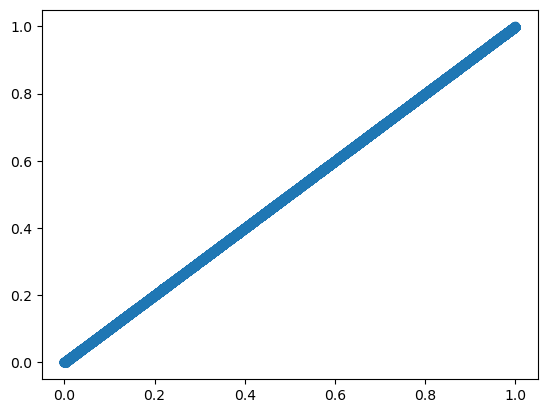

In [114]:
plt.plot(calc_df["diff_pval_adj"].sort_values(), comp["diff_pval_adj"].sort_values(), marker = "o", linestyle = "")
plt.show()

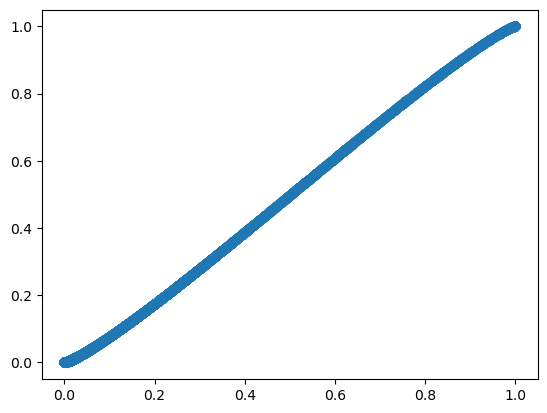

In [115]:
plt.plot(calc_df["equiv_pval_adj"].sort_values(), comp["equiv_pval_adj"].sort_values(), marker = "o", linestyle = "")
plt.show()

In [126]:
savecols = ["avg_group1_log2", "avg_group2_log2", "nnz_group1", "nnz_group2", 
            "eff_size", "avg_group1", "avg_group2", "fold_change", 
            "diff_pval", "equiv_pval", "diff_pval_adj", "equiv_pval_adj",
            "sig_diff", "sig_equiv"]
calc_df.rename({"muf" : "avg_group1_log2", "mug" : "avg_group2_log2"},axis=1,inplace=True)
calc_df["eff_size"] = calc_df["avg_group1_log2"] - calc_df["avg_group2_log2"]

for i in range(1,3):
      calc_df["avg_group{}".format(i)] = 2**calc_df["avg_group{}_log2".format(i)]
calc_df["fold_change"] = calc_df["avg_group1"]/calc_df["avg_group2"] 

for v in ["diff", "equiv"]:
    calc_df["sig_" + v] = False
    calc_df.loc[calc_df["{}_pval_adj".format(v)] < 0.05, "sig_{}".format(v)] = True

  # include effect size filter on significance    
calc_df.loc[(-delta <= calc_df["eff_size"]) & (calc_df["eff_size"] <= delta), "sig_diff"] = False    
calc_df.loc[(calc_df["eff_size"] > delta) | (calc_df["eff_size"] < -delta), "sig_equiv"] = False 

calc_df[savecols]


,avg_group1_log2,avg_group2_log2,nnz_group1,nnz_group2,eff_size,avg_group1,avg_group2,fold_change,diff_pval,equiv_pval,diff_pval_adj,equiv_pval_adj,sig_diff,sig_equiv
Gm43094,0.917133,0.000000,6,0,0.917133,1.888359,1.000000,1.888359,3.381317e-11,1.016286e-02,0.000001,0.017445,False,True
Scgn,6.825182,3.747797,6,6,3.077385,113.392540,13.433816,8.440829,2.074652e-10,1.000000e+00,0.000003,1.0,True,False
Prrxl1,6.083772,3.325149,6,6,2.758623,67.826258,10.022349,6.767501,3.306543e-09,9.999999e-01,0.000036,1.0,True,False
Gm7609,3.463566,0.000000,6,0,3.463566,11.031571,1.000000,11.031571,6.062924e-09,9.999999e-01,0.000049,1.0,True,False
Rfng,9.092809,9.510107,6,6,-0.417298,546.019601,729.167929,0.748826,8.537181e-09,1.628156e-10,0.000055,0.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zc3h8,6.294303,6.294354,6,6,-0.000051,78.482720,78.485497,0.999965,9.996444e-01,2.177132e-06,0.999713,0.000008,False,True
n.R5s197,1.892780,1.892667,6,6,0.000112,3.713500,3.713211,1.000078,9.996722e-01,1.870239e-03,0.999713,0.004023,False,True
Gm25821,0.685335,0.685499,4,3,-0.000164,1.608076,1.608258,0.999887,9.996799e-01,1.533340e-02,0.999713,0.024654,False,True
Olfr1301,0.449902,0.450075,2,2,-0.000173,1.365947,1.366111,0.999880,9.996823e-01,2.011207e-02,0.999713,0.03095,False,True


In [128]:
col = "sig_equiv"
(calc_df.sort_index()[col] != comp.sort_index()[col]).sum()

1651

In [123]:
calc_df.loc[(calc_df.sort_index()[col] != comp.sort_index()[col]).sort_values().index[-1]]

avg_group1_log2     6.060891
avg_group2_log2      5.35367
sf2                 0.057823
sg2                 0.089372
nnz_group1                 6
nnz_group2                 6
nf                         6
ng                         6
nu                        10
t0                  4.515273
t1                 10.899805
t-1                -1.869259
cdf_t0              0.999442
diff_pval           0.001116
cdf_t1              0.045559
cdf_t2                   0.0
equiv_pval          0.045559
diff_pval_adj       0.020147
equiv_pval_adj      0.060874
eff_size            0.707221
avg_group1         66.759012
avg_group2         40.889824
fold_change         1.632656
sig_diff                True
sig_equiv              False
Name: Ipcef1, dtype: object

In [125]:
comp.loc[(calc_df.sort_index()[col] != comp.sort_index()[col]).sort_values().index[-1]]

nnz_group1                 6
nnz_group2                 6
avg_group1_log2     6.060891
avg_group2_log2      5.35367
diff_pval           0.001116
equiv_pval          0.031565
eff_size            0.707221
avg_group1         66.759012
avg_group2         40.889824
fold_change         1.632656
diff_pval_adj       0.020147
sig_diff               False
equiv_pval_adj      0.042176
sig_equiv               True
Name: Ipcef1, dtype: object

In [106]:
calc_df

,avg_group1_log2,avg_group2_log2,sf2,sg2,nnz_group1,nnz_group2,nf,ng,nu,t0,...,cdf_t2,equiv_pval,diff_pval_adj,equiv_pval_adj,eff_size,avg_group1,avg_group2,fold_change,sig_diff,sig_equiv
A030001D20Rik,5.348811,5.416791,0.050955,0.078610,6,6,6,6,9.564273,-0.462611,...,0.000051,0.000051,0.855679,0.000157,-0.067980,40.752333,42.718562,0.953972,False,True
A030005L19Rik,3.373864,3.345660,0.031001,0.292402,6,6,6,6,6.048447,0.121484,...,0.002172,0.002837,0.975379,0.006106,0.028204,10.366554,10.165858,1.019742,False,True
A030012G06Rik,0.220109,0.165301,0.290688,0.163947,1,1,6,6,9.278887,0.199107,...,0.001898,0.003568,0.952218,0.007489,0.054808,1.164821,1.121400,1.038721,False,True
A030014E15Rik,0.706088,0.000000,0.708963,0.000000,3,0,6,6,5.000000,2.054105,...,0.002118,0.215794,0.321184,0.236744,0.706088,1.631375,1.000000,1.631375,False,False
A130006I12Rik,2.522444,2.400062,0.254875,0.549640,6,6,6,6,8.816473,0.334214,...,0.006893,0.020329,0.906751,0.031987,0.122381,5.745546,5.278260,1.088530,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n.R5s84,0.163123,0.187737,0.159656,0.211471,1,1,6,6,9.808797,-0.098967,...,0.001483,0.001483,0.979031,0.003371,-0.024614,1.119709,1.138976,0.983084,False,True
n.R5s85,0.698610,0.172058,0.356213,0.177623,4,1,6,6,8.993479,1.765278,...,0.000316,0.073472,0.352451,0.091767,0.526552,1.622940,1.126664,1.440482,False,False
n.R5s88,0.372120,0.000000,0.370754,0.000000,2,0,6,6,5.000000,1.496977,...,0.001336,0.026398,0.453607,0.039599,0.372120,1.294253,1.000000,1.294253,False,True
n.R5s98,0.000000,0.362372,0.000000,0.316352,0,2,6,6,5.000000,-1.578137,...,0.019523,0.019523,0.438028,0.030897,-0.362372,1.000000,1.285538,0.777884,False,True


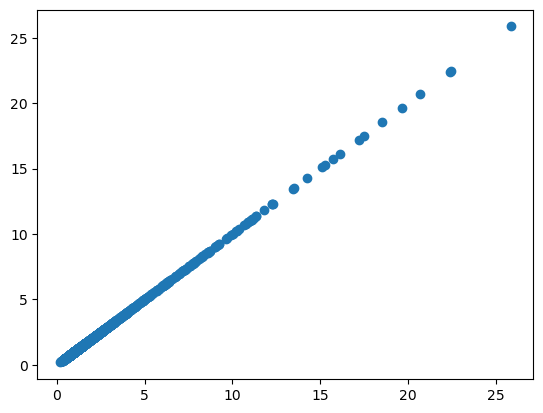

In [99]:
col = "fold_change"
plt.plot(calc_df[col].sort_values(), comp[col].sort_values(), marker = "o", linestyle = "")
plt.show()

In [1]:
calc_df

NameError: name 'calc_df' is not defined